# Baseline model: pre-trained U-Net

## Setting up environment and download ADE20K dataset

Install requiredrequired package

In [ ]:
import os
from tqdm import tqdm

In [ ]:
data_dir = "./data"
downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

In [ ]:
# Download ADE20K scene parsing dataset
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip -O {downloads_dir}/scene_parsing.zip
# !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip -O {downloads_dir}/scene_parsing_test.zip

!unzip -q -o {downloads_dir}'/scene_parsing.zip' -d {datasets_dir}
# !unzip -q -o {downloads_dir}'/scene_parsing_test.zip' -d {datasets_dir}
!rm -rf {downloads_dir}

--2022-05-08 01:19:56--  http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 967382037 (923M) [application/zip]
Saving to: ‘./data/downloads/scene_parsing.zip’

./data/downloads/sc 100%[===================>] 922.57M  12.9MB/s    in 98s     

2022-05-08 01:21:35 (9.40 MB/s) - ‘./data/downloads/scene_parsing.zip’ saved [967382037/967382037]



In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# delete gray scale images
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00001701.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00001701.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00003020.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00003020.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00008455.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00008455.png"
!rm -rf "/content/data/datasets/ADEChallengeData2016/images/training/ADE_train_00013508.jpg"
!rm -rf "/content/data/datasets/ADEChallengeData2016/annotations/training/ADE_train_00013508.png"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars

from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


### Baseline Dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
#folder_path = "/content/drive/MyDrive/MIT/6.869/Project/data/datasets/ADEChallengeData2016/"
folder_path = "/content/data/datasets/ADEChallengeData2016/"
split = "training"
# os.path.join(folder_path,'images', split, '*.jpg')
# glob.glob(os.path.join(folder_path,'images', split, '*.jpg'))

In [ ]:
import torch.utils.data as data
import glob

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, split="training"):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'images', split, '*.jpg')))
        self.mask_files =  sorted(glob.glob(os.path.join(folder_path,'annotations', split, '*.png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = PIL.Image.open(img_path)
        mask = PIL.Image.open(mask_path)

        image = np.asarray(transforms.Resize([512,512])(image))
        image = transforms.ToTensor()(np.array(image))
        mask = np.asarray(transforms.Resize([512,512])(mask))
        mask = mask.astype(np.int64)
        # if (image.shape[0] == 1):
        #   image = np.stack((image,)*3, axis=0)
        
        return image, torch.from_numpy(mask)#torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)//2

build training and validation dataloader

In [ ]:
train_data = DataLoaderSegmentation(folder_path)
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers = 4)
print("Check how many steps in one training epoch: ", len(train_data_loader))

Check how many steps in one training epoch:  1263


In [ ]:
validation_data = DataLoaderSegmentation(folder_path, split="validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 4)
print("Check how many steps in one validation epoch: ", len(validation_data_loader))

Check how many steps in one validation epoch:  125


### Visualized Dataset
Here we visualize the real image and the ground truth annotation done by human annotators. In annotation, each category will be asigned with a specific color. 

In [ ]:
img, seg = next(iter(train_data_loader))

In [ ]:
print("Batch size of image:", img.shape)
print("Batch size of annotation:", seg.shape)

Batch size of image: torch.Size([8, 3, 512, 512])
Batch size of annotation: torch.Size([8, 512, 512])


In [ ]:
PALETTE = torch.tensor([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20], [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0], [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255], [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0], [92, 0, 255], [30, 180, 120]
])

In [ ]:
def visualize_first_n(batch_img, batch_seg, n):
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(batch_img[i,:,:,:].permute((1,2,0)))
    ax.axis('off')
    ax.set_title('image {}'.format(i+1))
    i += 1

  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    if ax is None:
        break
    seg_mask = np.zeros((512,512,3))
    for k in range(512):
      for j  in range(512):
        seg_mask[k,j,:] = PALETTE[batch_seg[i,k,j].item()]/255.0
    ax.imshow(seg_mask)
    ax.axis('off')
    ax.set_title('annotation {}'.format(i+1))
    i += 1

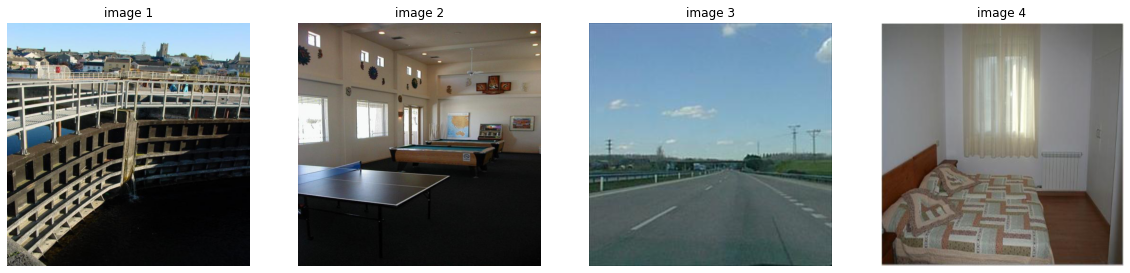

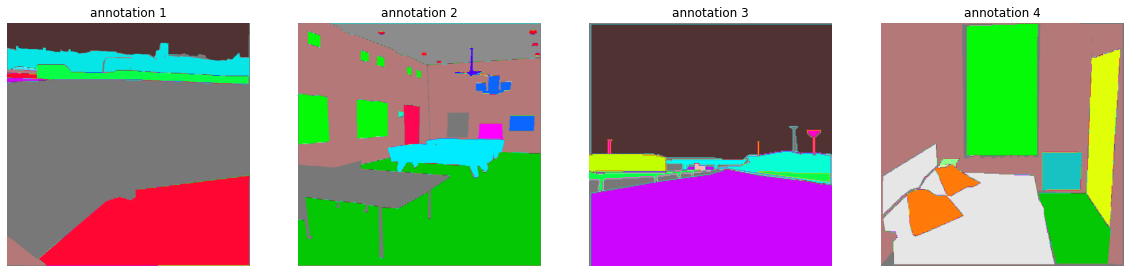

In [ ]:
visualize_first_n(img,seg,4)

## Baseline Model - U-Net

U-Net with pre-trained Resnet32 weights

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# execute auxiliary Python file
execfile("/content/Unet.py")
model = UnetResNet(encoder_name="resnet34", 
                           num_classes=151, 
                           input_channels=3, 
                           num_filters=32, 
                           Dropout=0.3).to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

### Training Baseline Model

In [ ]:
# training parameters
best_loss = 1000
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
train_step = len(train_data_loader)
val_step = len(validation_data_loader)

model.zero_grad()
for epoch in range(30):
    print("-" * 30)
    print(f"epoch {epoch + 1}/{40}")
    model.train()
    epoch_loss = 0
    step = 0
    for img, mask in tqdm(train_data_loader):
        # step += 1
        img = img.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = loss_function(outputs, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = train_step

    epoch_loss /= train_step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        # evaludate the validation set
        val_loss = 0
        for val_data in tqdm(validation_data_loader):
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = model(val_images)
            loss = loss_function(val_outputs, val_labels)
            val_loss += loss.item()
        val_loss /= val_step
        val_loss_values.append(val_loss)
        if val_loss < best_loss:
          best_loss = val_loss
          best_metric_epoch = epoch + 1
          torch.save(model.state_dict(), "best_unet_model.pth")
          print("new best metric model saved")
        print("current epoch: {} current loss: {:.4f} best loss: {:.4f} at epoch {}".format(epoch + 1, val_loss, best_loss, best_metric_epoch))


In [ ]:
# plot training loss and validation loss
import matplotlib.pyplot as plt
def plot_train_val_loss(epoch_loss_values, val_loss_values, file_name):
  plt.plot(np.arange(len(epoch_loss_values))+1, epoch_loss_values, label = "training")
  plt.xlabel("Epoch")
  # plt.ylabel("Training Cross-Entropy Loss")
  plt.plot(np.arange(len(val_loss_values))+1, val_loss_values, label = "validation")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-Entropy Loss")
  # plt.title("Validation")
  plt.legend()
  plt.savefig(fname = file_name)

In [ ]:
plot_train_val_loss(epoch_loss_values, val_loss_vaalues, "pretrained-Unet")

Load the best model

In [ ]:
model.load_state_dict(torch.load("/content/best_unet_model.pth"))

<All keys matched successfully>

### Visualize Prediction Result
Visualize the image, ground truth segmentation, and semantic prediction (on validation set).

In [ ]:
model.eval()
img_val, seg_val = next(iter(validation_data_loader))

In [ ]:
def visualize_prediction_n(batch_img, batch_seg, n, model):
  model.eval()
  visualize_first_n(batch_img,batch_seg,n)
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  model.eval()
  with torch.no_grad():
    prediction_raw = model(img_val.to(device))
    prediction = np.argmax(prediction_raw.cpu(), axis = 1)
    i=0
    for ax in ax.ravel():
      if ax is None:
        break
      pre_mask = np.zeros((512,512,3))
      for k in range(512):
        for j  in range(512):
          pre_mask[k,j,:] = PALETTE[prediction[i,k,j].item()]/255.0
      ax.imshow(pre_mask)
      ax.axis('off')
      ax.set_title('prediction {}'.format(i+1))
      i += 1
    plt.savefig("unet_pre_pred.png")

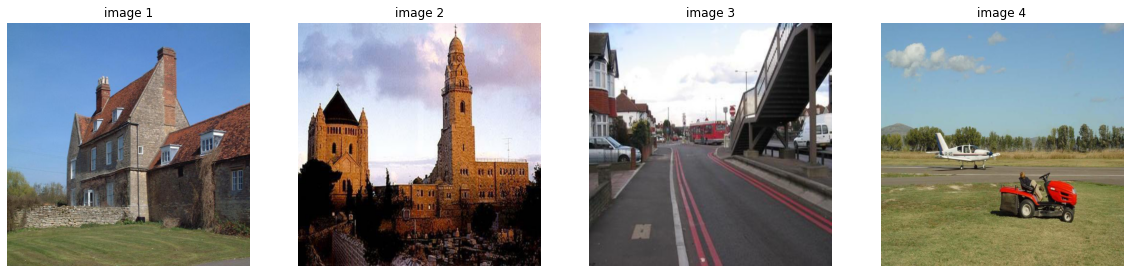

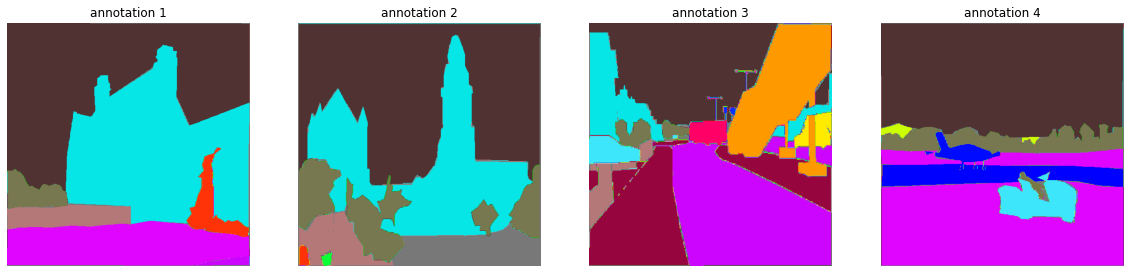

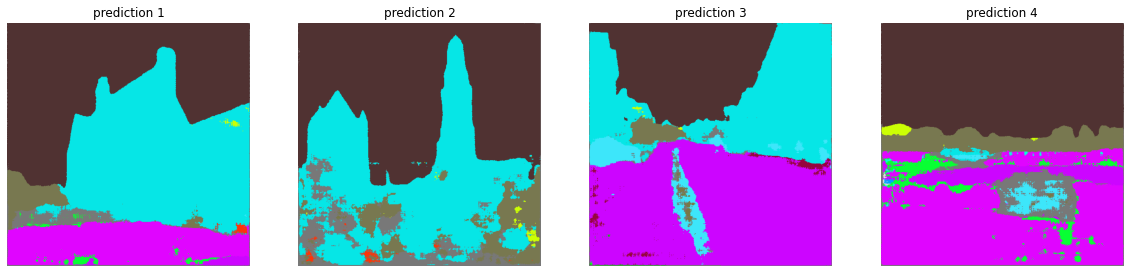

In [ ]:
visualize_prediction_n(img_val, seg_val, 4, model)

### Model Evaluation

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [ ]:
def intersectionAndUnion(imPred, imLab, numClass):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()

    imPred += 1
    imLab += 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab > 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    return (area_intersection, area_union)

In [ ]:
def accuracy(preds, label):
    valid = (label >= 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (valid_sum + 1e-10)
    return acc, valid_sum

In [ ]:
def evaluate(segmentation_module, loader):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    intersection_meter_50 = AverageMeter()
    union_meter_50 = AverageMeter()


    segmentation_module.eval()

    for img, seg in tqdm(validation_data_loader):
        # get the prediction here
        pred = model(img.to(device))
        pred = pred.detach().cpu()
        pred = np.argmax(pred, axis = 1)

        # calculate accuracy
        acc, pix = accuracy(pred, seg)
        intersection, union = intersectionAndUnion(pred, seg, 151)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)
        intersection_meter_50.update(intersection[0:50])
        union_meter_50.update(union[0:50])


    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    iou_50 = intersection_meter_50.sum / (union_meter_50.sum + 1e-10)
    f= open("/content/iou_baseline.txt","w+")
    for i, _iou in enumerate(iou):
      print('class [{}], IoU: {:.4f}'.format(i, _iou))
      f.write('{}, {:.4f}'.format(i, _iou))
      f.write('\n')

    print('[Eval Summary]:')
    print('Mean IoU: {:.4f}, Mean IoU first 50 classes: {:.4f}, Accuracy: {:.4f}%'
          .format(iou.mean(), iou_50.mean(), acc_meter.average()*100))


In [ ]:
evaluate(model, validation_data_loader)

  0%|          | 0/125 [00:00<?, ?it/s]

class [0], IoU: 0.1349
class [1], IoU: 0.4735
class [2], IoU: 0.5668
class [3], IoU: 0.8541
class [4], IoU: 0.5354
class [5], IoU: 0.5031
class [6], IoU: 0.6372
class [7], IoU: 0.5265
class [8], IoU: 0.4941
class [9], IoU: 0.3623
class [10], IoU: 0.3987
class [11], IoU: 0.1476
class [12], IoU: 0.1127
class [13], IoU: 0.2891
class [14], IoU: 0.0894
class [15], IoU: 0.0087
class [16], IoU: 0.1548
class [17], IoU: 0.2531
class [18], IoU: 0.1412
class [19], IoU: 0.2623
class [20], IoU: 0.1530
class [21], IoU: 0.3181
class [22], IoU: 0.0225
class [23], IoU: 0.3427
class [24], IoU: 0.0240
class [25], IoU: 0.0015
class [26], IoU: 0.0000
class [27], IoU: 0.1755
class [28], IoU: 0.0325
class [29], IoU: 0.0837
class [30], IoU: 0.1636
class [31], IoU: 0.0000
class [32], IoU: 0.0003
class [33], IoU: 0.0000
class [34], IoU: 0.0000
class [35], IoU: 0.0001
class [36], IoU: 0.0566
class [37], IoU: 0.1113
class [38], IoU: 0.1259
class [39], IoU: 0.0000
class [40], IoU: 0.0677
class [41], IoU: 0.0000
cl